In [1]:
from PIL import Image
import time

import seaborn as sns
from sklearn.metrics import confusion_matrix

import cv2
import pandas as pd
import numpy as np
import time
import tensorflow as tf
import zipfile
import matplotlib.pyplot as plt
import os
import glob
%matplotlib inline

from google.colab.patches import cv2_imshow
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input, concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
zip_file = zipfile.ZipFile(file = "/content/drive/MyDrive/Deep_Learning/Face_Recognation/Material.zip",mode = "r")
zip_file.extractall("./")
zip_file.close()

zip_file = zipfile.ZipFile(file = "/content/Material/fer2013.zip",mode = "r")
zip_file.extractall("./")
zip_file.close()

In [4]:
classes = ['Angry','Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'] 

total = []
emotions = []
name_img = []
name_emotion = []

max_photo = 3000

for i,classe in enumerate(classes):
    imgs_training = glob.glob("/content/fer2013/train/"+classe+"/*")
    a = 0
    
    for img in imgs_training:
        total.append(img)
        name_img.append(str(img.split("/")[-1]))
        emotions.append(i)
        name_emotion.append(classe)
        a = a+1
        #if a >=max_photo:
        #    break
    
    #print("Number of Images "+ classe + " = "+str(len(imgs_training)))

dataset = pd.DataFrame()
dataset["img"] = name_img
dataset["emotion"] = emotions
dataset["class"] = name_emotion


####################################################
 

width,height = 48,48

faces = []
samples = 0
t = time.time()
t_total = time.time()

for face in total:
    img = cv2.imread(face,0)
    img = np.asarray(img).reshape(width,height)
    img = cv2.resize(img,(width,height))

    samples+=1
    faces.append(img)

    if (samples % 200 ==0):
        #print(str(samples) + " photo upload [+" + str(round(time.time()- t,2)) + "s]")
        t=time.time()

    #if samples <= 5:
    #    cv2_imshow(img)

#print("Total Time : ",str(time.time() - t_total))


####################################################

faces = np.asarray(faces)
faces = np.expand_dims(faces,-1)

def normalizer(x):
    x = x.astype("float32")
    x = x / 255.0
    return x

faces = normalizer(faces)


labels = pd.get_dummies(dataset["emotion"]).values

#####################################################

X_train,X_test,y_train,y_test = train_test_split(faces,labels,test_size = 0.1, random_state = 42)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size = 0.1, random_state = 41)

#print('Number of images in the training set: ', len(X_train))
#print('Number of images in the test set: ', len(X_test))
#print('Number of images in the validation set: ', len(X_val))

np.save("mod_xtest_incept",X_test)
np.save("mod_ytest_incept",y_test)

####################################################

num_classes = 7
width, height = 48, 48
batch_size = 128
epochs = 100

model = Sequential()

input_img = Input(shape=(width, height, 1))

layer1 = Conv2D(10, (3, 3), padding='same', activation='relu')(input_img)
layer1_2 = Conv2D(20, (3, 3), padding='same', activation='relu')(layer1)
layer2 = MaxPooling2D(pool_size=(3, 3))(layer1_2)
bn1 = BatchNormalization()(layer2)

layer3 = Conv2D(30, (3, 3), padding='same', activation='relu')(bn1)
layer3_2 = Conv2D(40, (3, 3), padding='same', activation='relu')(layer3)
layer4 = MaxPooling2D(pool_size=(3, 3))(layer3_2)
bn2 = BatchNormalization()(layer4)

layer5 = Conv2D(50, (3, 3), padding='same', activation='relu')(bn2)
layer5_2 = Conv2D(60, (3, 3), padding='same', activation='relu')(layer5)
layer6 = MaxPooling2D(pool_size=(3, 3))(layer5_2)
bn3 = BatchNormalization()(layer6)

Conv11 = Conv2D(1, (1, 1), padding='same', activation='relu')(bn3)
Conv33 = Conv2D(4, (3, 3), padding='same', activation='relu')(bn3)
Conv332 = Conv2D(1, (3, 3), padding='same', activation='relu')(Conv33)
Conv55 = Conv2D(4, (5, 5), padding='same', activation='relu')(bn3)
Conv552 = Conv2D(1, (3, 3), padding='same', activation='relu')(Conv55)
#Pool33 = MaxPooling2D(pool_size=(3, 3))(bn3)
#ConvPool1 = Conv2D(4, (1, 1), padding='same', activation='relu')(Pool33)

intermediate1 = concatenate([Conv11, Conv332, Conv552], axis=1)

Conv2_11 = Conv2D(1, (1, 1), padding='same', activation='relu')(intermediate1)
Conv2_33 = Conv2D(4, (3, 3), padding='same', activation='relu')(intermediate1)
Conv2_332 = Conv2D(1, (3, 3), padding='same', activation='relu')(Conv2_33)
Conv2_55 = Conv2D(4, (5, 5), padding='same', activation='relu')(intermediate1)
Conv2_552 = Conv2D(1, (3, 3), padding='same', activation='relu')(Conv2_55)
#Pool2_33 = MaxPooling2D(pool_size=(3, 3))(intermediate1)
#ConvPool2 = Conv2D(4, (1, 1), padding='same', activation='relu')(Pool2_33)

intermediate2 = concatenate([Conv2_11, Conv2_332, Conv2_552], axis=1)

Conv3_11 = Conv2D(1, (1, 1), padding='same', activation='relu')(intermediate2)
Conv3_33 = Conv2D(4, (3, 3), padding='same', activation='relu')(intermediate2)
Conv3_332 = Conv2D(1, (3, 3), padding='same', activation='relu')(Conv3_33)
Conv3_55 = Conv2D(4, (5, 5), padding='same', activation='relu')(intermediate2)
Conv3_552 = Conv2D(1, (3, 3), padding='same', activation='relu')(Conv3_55)
#Pool3_33 = MaxPooling2D(pool_size=(3, 3))(intermediate2)
#ConvPool3 = Conv2D(4, (1, 1), padding='same', activation='relu')(Pool3_33)

intermediate3 = concatenate([Conv3_11, Conv3_332, Conv3_552], axis=1)

#Pool4 = MaxPooling2D(pool_size=(3, 3))(intermediate3)

Flat = Flatten()(intermediate3)

Dense1 = Dense(25, activation='relu')(Flat)
Dense2 = Dense(15, activation='relu')(Dense1)
Dense3 = Dense(num_classes, activation='softmax')(Dense2)

model = Model([input_img], Dense3)

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 48, 48, 10)   100         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 48, 48, 20)   1820        ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 16, 16, 20)   0           ['conv2d_1[0][0]']               
                                                                                              

In [5]:
datagen = ImageDataGenerator(
      rotation_range=10,
      shear_range=0.1,
      zoom_range=0.1,
      width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True,
      fill_mode='nearest')

model.compile(loss=categorical_crossentropy,
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])

file_model =  "model_inception.h5"
file_model_json =  "model_inception.json" 

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1)
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(file_model, monitor='val_loss', verbose=1, save_best_only=True)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [6]:
model_json = model.to_json()
with open(file_model_json, "w") as json_file:
    json_file.write(model_json)

In [7]:
history = model.fit_generator(
          datagen.flow(X_train, y_train, batch_size=batch_size),
          epochs=epochs,
          verbose=1,
          validation_data= (X_val, y_val),
          validation_steps = len(X_val) // batch_size,
          steps_per_epoch = len(X_train) // batch_size,
          callbacks=[lr_reducer, early_stopper, checkpointer])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/100
181/181 [==============================] - ETA: 0s - loss: 1.8247 - accuracy: 0.2418
Epoch 1: val_loss improved from inf to 1.83565, saving model to model_inception.h5
181/181 [==============================] - 22s 99ms/step - loss: 1.8247 - accuracy: 0.2418 - val_loss: 1.8357 - val_accuracy: 0.2492 - lr: 0.0010
Epoch 2/100
181/181 [==============================] - ETA: 0s - loss: 1.6898 - accuracy: 0.3024
Epoch 2: val_loss improved from 1.83565 to 1.78479, saving model to model_inception.h5
181/181 [==============================] - 14s 79ms/step - loss: 1.6898 - accuracy: 0.3024 - val_loss: 1.7848 - val_accuracy: 0.2624 - lr: 0.0010
Epoch 3/100
181/181 [==============================] - ETA: 0s - loss: 1.6354 - accuracy: 0.3204
Epoch 3: val_loss improved from 1.78479 to 1.67201, saving model to model_inception.h5
181/181 [==============================] - 16s 89ms/step - loss: 1.6354 - accuracy: 0.3204 - val_loss: 1.6720 - val_accuracy: 0.3135 - lr: 0.0010
Epoch 4/100
18

In [8]:
scores = model.evaluate(np.array(X_test),np.array(y_test),batch_size = batch_size)
print("Accuracy : ", scores[1] )
print("Loss : ", scores[0])

23/23 [==============================] - 1s 21ms/step - loss: 1.0914 - accuracy: 0.5838
Accuracy :  0.5837687253952026
Loss :  1.0913689136505127


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


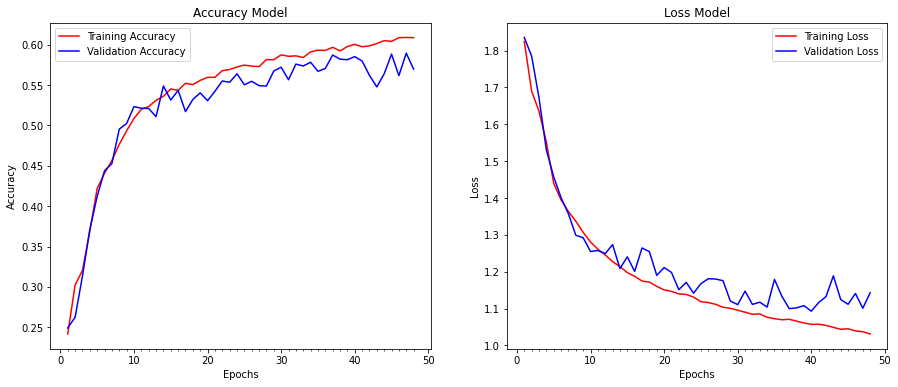

In [9]:
def history_graph(history):

    fig,ax = plt.subplots(1,2,figsize =(15,6))
    ax[0].plot(range(1,len(history.history["accuracy"]) + 1), history.history["accuracy"],"r")
    ax[0].plot(range(1,len(history.history["val_accuracy"]) + 1), history.history["val_accuracy"],"b")
    ax[0].set_title("Accuracy Model")
    ax[0].set_ylabel("Accuracy")
    ax[0].set_xlabel("Epochs")
    ax[0].set_xticks(np.arange(1,len(history.history["accuracy"]) + 1),
                     len(history.history["accuracy"]) / 10)
    
    ax[0].legend(["Training Accuracy", "Validation Accuracy"])
    
    ax[1].plot(range(1,len(history.history["loss"]) + 1), history.history["loss"],"r")
    ax[1].plot(range(1,len(history.history["val_loss"]) + 1), history.history["val_loss"],"b")
    ax[1].set_title("Loss Model")
    ax[1].set_ylabel("Loss")
    ax[1].set_xlabel("Epochs")
    ax[1].set_xticks(np.arange(1,len(history.history["loss"]) + 1),
                     len(history.history["loss"]) / 10)
    
    ax[1].legend(["Training Loss", "Validation Loss"])

history_graph(history)

In [10]:
true_y = []
pred_y = []

y = np.load("/content/mod_ytest_incept.npy")
x = np.load("/content/mod_xtest_incept.npy")

json_file = open(file_model_json,"r")
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights(file_model)

y_pred = loaded_model.predict(x)
yp = y_pred.tolist()
yt = y.tolist()
count = 0

for i in range(len(y)):
    yy = max(yp[i])
    yyt = max(yt[i])
    pred_y.append(yp[i].index(yy))
    true_y.append(yt[i].index(yyt))
    if (yp[i].index(yy) == yt[i].index(yyt)):
        count+=1

acc = (count/len(y))*100
np.save("truey_incept",true_y)
np.save("predy_incept",pred_y)
print("Accuracy Test : " + str(round(acc,2)) + "%")

Accuracy Test : 59.32%


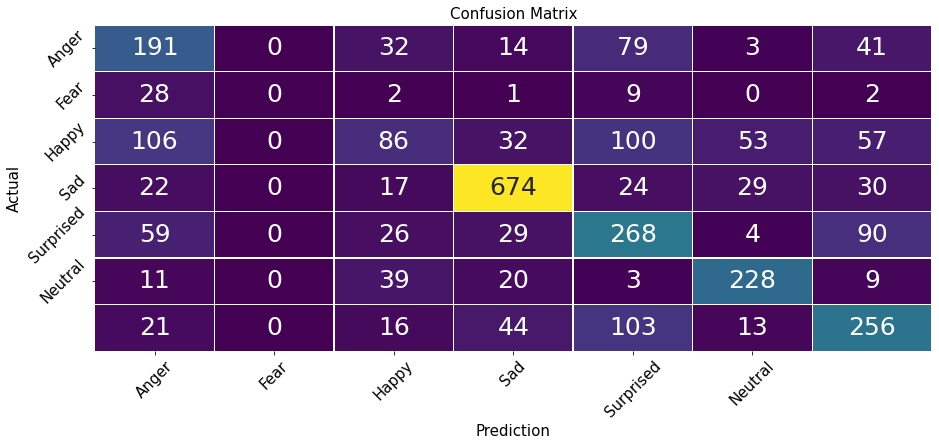

In [11]:
y_true = np.load("/content/truey_incept.npy")
y_pred = np.load("/content/predy_incept.npy")

expressions = ['Anger', 'Fear', 'Happy', 'Sad', 'Surprised', 'Neutral']

def confusion_matrix_graph(y_true,y_pred,label):
    cm = confusion_matrix(y_true,y_pred)
    size = 15

    plt.figure(figsize = (15,6))
    sns.heatmap(cm,annot=True,fmt = "d",cmap = "viridis", cbar = False, xticklabels=label,yticklabels = label,
                linecolor="white",linewidths=.2,annot_kws = {"size":25,})
    

    plt.title("Confusion Matrix",fontsize = size)
    plt.ylabel("Actual",fontsize = size)
    plt.xlabel("Prediction",fontsize = size)
    plt.yticks(rotation = 45,fontsize = size)
    plt.xticks(rotation = 45,fontsize = size)
    plt.show()

confusion_matrix_graph(y_true,y_pred,expressions)

# Testing

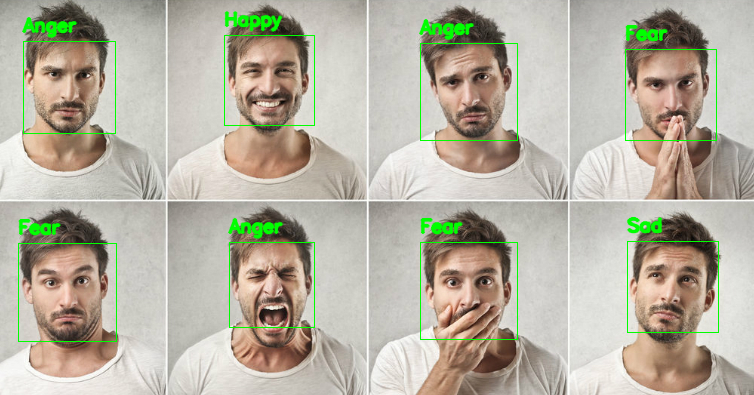

In [12]:
loaded_model = tf.keras.models.load_model("/content/model_inception.h5")
expressions = ['Anger','Disgust','Fear', 'Happy', 'Sad', 'Surprised', 'Neutral']

img = cv2.imread("/content/Material/testes/teste02.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
face_cascade = cv2.CascadeClassifier("/content/Material/haarcascade_frontalface_default.xml")
faces = face_cascade.detectMultiScale(gray, 1.1, 3)

for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 1)
    roi_gray = gray[y:y + h, x:x + w]
    roi_gray = roi_gray.astype("float") / 255.0
    cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray, (48, 48)), -1), 0)
    cv2.normalize(cropped_img, cropped_img, alpha=0, beta=1, 
                  norm_type=cv2.NORM_L2, dtype=cv2.CV_32F)
    prediction = loaded_model.predict(cropped_img)[0]
    cv2.putText(img, expressions[int(np.argmax(prediction))], (x, y - 10), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2, cv2.LINE_AA)
cv2_imshow(img)